In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.outlier_handling import winsorize_column, remove_outliers_zscore, remove_outliers_iqr
from src.data_preprocessing import fill_numeric_missing_values, fill_categorical_missing_values
from src.transformations import log_transform_column, sqrt_transform_column
from src.user_engagement_analysis import aggregate_engagement_metrics, normalize_metrics, apply_kmeans, compute_cluster_stats, plot_engagement_clusters, elbow_method

In [2]:
DATABASE_TYPE = 'postgresql'
DBAPI = 'psycopg2'
HOST = 'localhost'
PORT = '5432'
DATABASE = 'Week2'
USER = 'postgres'
PASSWORD = '183153'

In [3]:
engine = create_engine(f'{DATABASE_TYPE}+{DBAPI}://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}')

In [4]:
query = "SELECT * FROM xdr_data;"
data = pd.read_sql(query, engine)

In [5]:
data.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

In [7]:
data.describe()

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
count,1.490100e+05,150000.000000,150000.000000,1.500000e+05,1.494310e+05,1.489350e+05,1.494290e+05,122172.000000,122189.000000,150000.000000,...,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500000e+05,1.500000e+05
mean,1.013887e+19,499.188200,498.800880,1.046086e+05,2.082016e+14,4.188282e+10,4.847455e+13,109.795706,17.662883,13300.045927,...,1.163407e+07,1.100941e+07,1.162685e+07,1.100175e+07,4.220447e+08,8.288398e+06,4.211005e+08,8.264799e+06,4.112121e+07,4.546434e+08
std,2.893173e+18,288.611834,288.097653,8.103762e+04,2.148809e+10,2.447443e+12,2.241637e+13,619.782739,84.793524,23971.878541,...,6.710569e+06,6.345423e+06,6.725218e+06,6.359490e+06,2.439675e+08,4.782700e+06,2.432050e+08,4.769004e+06,1.127639e+07,2.441429e+08
min,6.917538e+18,0.000000,0.000000,7.142000e+03,2.040471e+14,3.360100e+10,4.400152e+11,0.000000,0.000000,0.000000,...,5.300000e+01,1.050000e+02,4.200000e+01,3.500000e+01,2.516000e+03,5.900000e+01,3.290000e+03,1.480000e+02,2.866892e+06,7.114041e+06
25%,7.349883e+18,250.000000,251.000000,5.744050e+04,2.082014e+14,3.365130e+10,3.546071e+13,32.000000,2.000000,43.000000,...,5.833501e+06,5.517965e+06,5.777156e+06,5.475981e+06,2.104733e+08,4.128476e+06,2.101869e+08,4.145943e+06,3.322201e+07,2.431068e+08
50%,7.349883e+18,499.000000,500.000000,8.639900e+04,2.082015e+14,3.366371e+10,3.572201e+13,45.000000,5.000000,63.000000,...,1.161602e+07,1.101345e+07,1.164222e+07,1.099638e+07,4.234081e+08,8.291208e+06,4.218030e+08,8.267071e+06,4.114331e+07,4.558411e+08
75%,1.304243e+19,749.000000,750.000000,1.324302e+05,2.082018e+14,3.368349e+10,8.611970e+13,70.000000,15.000000,19710.750000,...,1.744852e+07,1.651556e+07,1.747048e+07,1.650727e+07,6.331742e+08,1.243162e+07,6.316918e+08,1.238415e+07,4.903424e+07,6.657055e+08
max,1.318654e+19,999.000000,999.000000,1.859336e+06,2.140743e+14,8.823971e+14,9.900120e+13,96923.000000,7120.000000,378160.000000,...,2.325910e+07,2.201196e+07,2.325919e+07,2.201196e+07,8.434419e+08,1.655879e+07,8.434425e+08,1.655882e+07,7.833131e+07,9.029696e+08


In [8]:
data.isnull().sum()

Bearer Id                                      991
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

In [9]:
high_skew_cols = ['MSISDN/Number', 'IMSI', 'TCP DL Retrans. Vol (Bytes)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)']
log_transform_cols = ['MSISDN/Number', 'IMSI', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Total UL (Bytes)', 'Total DL (Bytes)']
sqrt_transform_cols = ['UL TP < 10 Kbps (%)', 'Gaming DL (Bytes)', 'Social Media DL (Bytes)']
zscore_cols = ['TCP DL Retrans. Vol (Bytes)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)']
iqr_cols = ['UL TP < 10 Kbps (%)', 'Gaming DL (Bytes)', 'Social Media DL (Bytes)']


In [10]:
def process_outliers(data, high_skew_cols, log_transform_cols, sqrt_transform_cols, zscore_cols, iqr_cols):
    for col in high_skew_cols:
        data[col] = winsorize_column(data[col])
    
    for col in log_transform_cols:
        data[col] = log_transform_column(data[col])
    
    for col in sqrt_transform_cols:
        data[col] = sqrt_transform_column(data[col])
    
    for col in zscore_cols:
        data = remove_outliers_zscore(data, col)
    
    for col in iqr_cols:
        data[col] = remove_outliers_iqr(data[col])
    
    return data

In [11]:
processed_data = process_outliers(data, high_skew_cols, log_transform_cols, sqrt_transform_cols, zscore_cols, iqr_cols)

In [12]:
processed_data

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,32.969527,24.239723,3.552121e+13,9.16456699548519E+015,...,1.585461e+07,2.501332e+06,8.198936e+06,9.656251e+06,16675.799921,1.434415e+07,1.717444e+08,8.814393e+06,17.419642,19.548462
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,32.969529,24.240225,3.579401e+13,L77566A,...,2.024740e+07,1.911173e+07,1.833841e+07,1.722713e+07,24672.861083,1.170709e+06,5.269042e+08,1.505514e+07,17.800791,20.297677
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,32.969522,24.242561,3.528151e+13,D42335A,...,1.972566e+07,1.469958e+07,1.758779e+07,6.163408e+06,15152.050059,3.956300e+05,4.106926e+08,4.215763e+06,17.143551,19.449612
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,32.969527,24.242256,3.535661e+13,T21824A,...,2.138812e+07,1.514664e+07,1.399465e+07,1.097942e+06,28276.105690,1.084972e+07,7.490399e+08,1.279728e+07,17.584222,20.556064
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,32.969527,24.240758,3.540701e+13,D88865A,...,1.525938e+07,1.896287e+07,1.712458e+07,4.152180e+05,22971.879505,3.529801e+06,5.507095e+08,1.391032e+07,17.467280,20.159635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,7.277826e+18,4/29/2019 7:28,451.0,4/30/2019 6:02,214.0,81230.0,32.969531,24.239299,3.548311e+13,D20434A,...,1.619167e+07,1.176343e+07,1.788370e+07,1.967816e+07,22947.977536,9.197207e+06,3.264510e+06,1.348742e+07,17.869534,20.168445
149997,7.349883e+18,4/29/2019 7:28,483.0,4/30/2019 10:41,187.0,97970.0,32.969529,24.239679,3.566051e+13,D10223C,...,1.387723e+07,8.288284e+06,1.935015e+07,2.129315e+07,25037.832614,4.735033e+06,7.121804e+08,2.457758e+06,17.482530,20.317774
149998,1.311448e+19,4/29/2019 7:28,283.0,4/30/2019 10:46,810.0,98249.0,32.969528,24.238443,3.572121e+13,T51102A,...,2.266051e+07,1.855903e+06,9.963942e+06,5.065760e+06,23527.419833,1.339432e+07,1.211009e+08,1.131473e+07,17.368348,20.200345
149999,1.311448e+19,4/29/2019 7:28,696.0,4/30/2019 10:40,327.0,97910.0,32.969530,24.238376,8.618620e+13,L88342B,...,8.817106e+06,8.305402e+06,3.322253e+06,1.317259e+07,18775.967911,2.529475e+06,8.147131e+08,1.406930e+06,17.204166,19.734125


In [13]:
processed_data.isnull().sum()

Bearer Id                                      986
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           566
MSISDN/Number                                 1055
IMEI                                           568
Last Location Name                            1148
Avg RTT DL (ms)                              27827
Avg RTT UL (ms)                              27810
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96607
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

In [14]:
data = fill_categorical_missing_values(processed_data)
data = fill_numeric_missing_values(processed_data)

In [15]:
data.isnull().sum()

Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

In [16]:
engagement_metrics = aggregate_engagement_metrics(data)

In [17]:
engagement_metrics

,sessions frequency,session duration,Total UL (Bytes),Total DL (Bytes),total_traffic
Bearer Id,,,,,
6.917538e+18,1,24534.0,17.546122,20.031562,37.577684
6.917538e+18,1,21489.0,17.471185,20.380140,37.851325
6.917538e+18,1,27786.0,16.559502,20.565987,37.125489
6.917538e+18,1,15635.0,17.719616,20.531847,38.251463
6.917538e+18,1,24264.0,16.905801,20.253195,37.158996
...,...,...,...,...,...
1.318654e+19,1,80024.0,17.382580,18.794264,36.176844
1.318654e+19,1,145291.0,17.404282,19.773939,37.178221
1.318654e+19,1,86399.0,17.396790,20.587090,37.983879


In [18]:
normalized_metrics = normalize_metrics(engagement_metrics)

In [19]:
normalized_metrics

,sessions frequency,session duration,total_traffic
0,-0.04085,-0.544027,-0.037188
1,-0.04085,-0.562038,-0.034486
2,-0.04085,-0.524791,-0.041652
3,-0.04085,-0.596664,-0.030536
4,-0.04085,-0.545624,-0.041321
...,...,...,...
133389,-0.04085,-0.215808,-0.051016
133390,-0.04085,0.170241,-0.041131
133391,-0.04085,-0.178100,-0.033178
133392,-0.04085,-0.178100,-0.039945


In [20]:
clustered_data, kmeans_model = apply_kmeans(normalized_metrics, k=3)

In [21]:
kmeans_model

KMeans(n_clusters=3, random_state=0)

In [22]:
 cluster_stats = compute_cluster_stats(clustered_data, engagement_metrics)

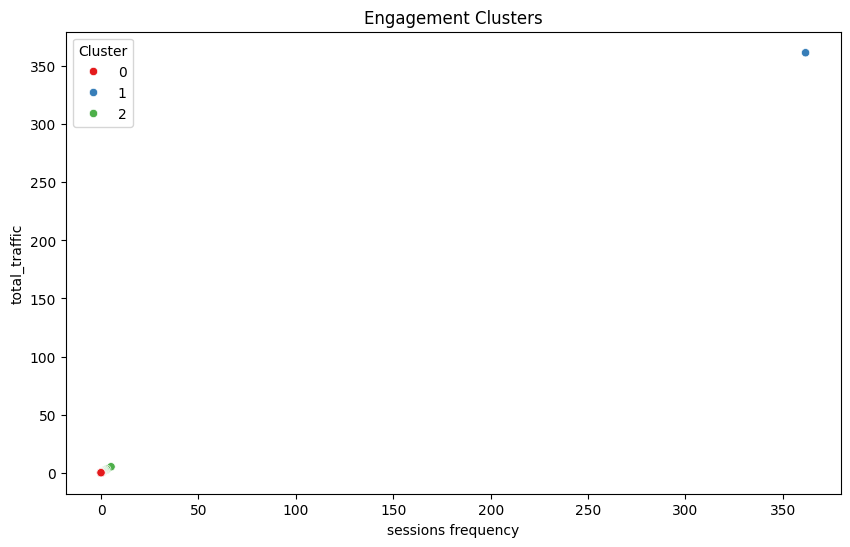

In [23]:
plot_engagement_clusters(clustered_data)

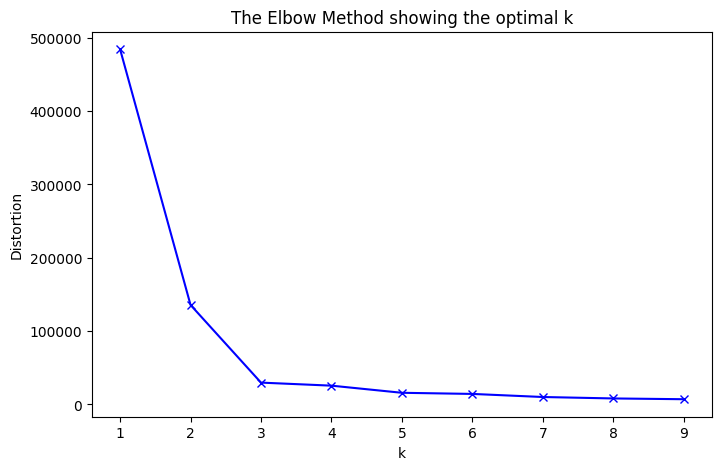

In [24]:
   elbow_method(normalized_metrics)